# Co-rotating vortices

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams['figure.figsize'] = (10,6)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys

if sys.platform == "darwin":
    %env CC=gcc-10

env: CC=gcc-10


In [4]:
%load_ext fortranmagic

In [5]:
%%fortran --f90flags "-fopenmp"  --extra "-lgomp"
subroutine biot ( n, xp, yp, op, up, vp )
  implicit none
  integer, intent(in)  :: n
  real(8), intent(in)  :: xp( n ), yp( n ), op( n )
  real(8), intent(out) :: up( n ), vp( n )
  !f2py optional , depend(a) :: n=len(xp)
        
  integer :: k, j
  real(8) :: dpi, a1, a12, a122, r2, r22, r2a1, r2a13
  real(8) :: f_ik, usum, vsum, dx, dy

  dpi   = 8d0 * atan( 1d0 )

  a1    = .05
  a12   = a1*a1
  a122  = a12*a12
    
  !$OMP PARALLEL DO DEFAULT(FIRSTPRIVATE) SHARED(up, vp)
  do  k = 1, n

    usum = 0
    vsum = 0
    do j = 1, n
        dx    = xp( j ) - xp( k )
        dy    = yp( j ) - yp( k )
        r2    = dx * dx + dy * dy
        if ( r2 > 1e-12 ) then
            r22   = r2 * r2
            r2a1  = r2 + a12
            r2a13 = r2a1 * r2a1 * r2a1
            f_ik  = ( r22 + 3d0*a12*r2 + 4d0*a122 ) / r2a13 
            usum = usum + dy * op(j) * f_ik
            vsum = vsum - dx * op(j) * f_ik 
        end if
    end do

    up(k) = usum / dpi 
    vp(k) = vsum / dpi 
            
   end do
   !$OMP END PARALLEL DO

end subroutine biot


In [6]:
def distrib(ray, nray = 10, nsec = 6, gauss=True, gam0 = 1.0, eps= 0):
    
    """
        Particles distributed evenly spaced into a disc.
         rf,zf : particles positions
         ds    : particle surface size 
         cir   : particle circulation
         dr    : size step along radial axis
         nray  : nb of points along adial axis
         dray  : particle ray in the center
         ray   : disc ray
         gam0  : total strength of the vortex 
         surf  : disc surface
         nsec  : number of particles around the center particle
         eps   : ellipsis parameter
         
    """

    pi = np.pi
    
    dr = ray / (nray + 0.5)
    dray = 0.5 * dr  
    surf = pi * ray * ray
    dtheta = 2.0 * pi / nsec

    k = 0
    rf = [0.0]
    zf = [0.0]
    ds = [pi * dray * dray]

    if gauss:
        gamt = gam0 / (1. - np.exp(-1.0))
        cf = [gamt * (1. - np.exp(-(dray / ray) ** 2))]  # gaussian
    else:
        cf = [gam0 * ds[k] / surf]  # uniform

    r1 = dray
    s1 = pi * r1 ** 2
    nsec0 = nsec
    nsec = 0

    for i in range(nray):

        nsec = nsec + nsec0
        dtheta = 2.0 * pi / nsec
        r = (i + 1) * dr

        r2  = r + 0.5 * dr
        s2  = pi * r2 ** 2
        dss = s2 - s1
        s1  = s2

        for j in range(nsec):

            k = k + 1
            theta = (j + 1) * dtheta
            sigma = r * (1.0 + eps * np.cos(2.0 * theta))
            rf.append(sigma * np.cos(theta))
            zf.append(sigma * np.sin(theta))
            ds.append(dss / nsec)
            if gauss:  # gaussian
                q = 0.5 * (np.exp(-(r1 / ray) ** 2) - np.exp(-(r2 / ray) ** 2))
                strength = gamt * dtheta / pi * q
            else:      # uniform
                strength = gam0 * ds[k] / surf
            
            cf.append(strength)
                
        r1 = r2
        kd = k - nsec + 1

    nr = k
    print (len(rf),len(zf),len(cf))

    ssurf = np.sum(ds)
    sgam  = np.sum(cf)

    print('toal number of particles :', nr)
    print('check surface :', (surf), ' - ', (ssurf))
    if (gauss):
        print('check vortex strength :', (gam0), ' ; ', (sgam))
    else:
        print('check vortex strength :', (gam0), ' ; ', (sgam))
        
    

    return np.array(rf), np.array(zf), np.array(ds), np.array(cf)

8201 8201 8201
toal number of particles : 8200
check surface : 3.141592653589793  -  3.141592653589793
check vortex strength : 1.0  ;  1.0


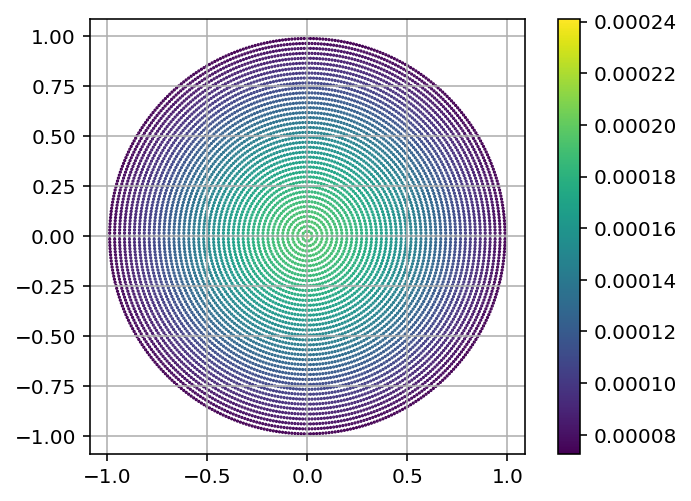

In [7]:
r, z, s, g = distrib(1.0,nray = 40,nsec = 10)
plt.scatter(r, z, 1e3*s, g)
plt.axis('scaled')
plt.grid(True)
plt.colorbar();

In [8]:
nstep = 1
amach = 0.1
nproc = 1
dt    = 0.1

pi = np.pi
r0 = 0.6
u0 = amach

#gam0   = u0 * 2.0 * pi / 0.7 * r0	!gaussienne
#gam0   = 2. * pi * r0 * u0		!constant
gam0   = 2. * pi / 10.0

aom    = gam0 / ( pi * r0**2 )	#Amplitude du vortex
tau    = 8.0 * pi**2 / gam0	#Periode de co-rotation
gomeg  = gam0/ (4.0*pi)		#Vitesse angulaire

print( " --------------------------------------------- ")
print( " steps : ", nstep)
print( " time step : ", dt)
print( " aom = ", aom)
print( " r0 = ", r0)
print( " strength = ", gam0)
print( " rotation speed gomeg = ", gomeg)
print( " corotation period = ", tau)
print( " --------------------------------------------- ")

rf, zf , ds, gam =  distrib( r0, nray = 20, nsec = 8 )
n = 2 * rf.size
X = np.zeros((n,2),dtype=np.float64)
X[:,0] = np.concatenate([rf, rf])
X[:,1] = np.concatenate([zf + 1., zf - 1])
op = np.concatenate([gam,gam])

 --------------------------------------------- 
 steps :  1
 time step :  0.1
 aom =  0.5555555555555556
 r0 =  0.6
 strength =  0.6283185307179586
 rotation speed gomeg =  0.05
 corotation period =  125.66370614359172
 --------------------------------------------- 
1681 1681 1681
toal number of particles : 1680
check surface : 1.1309733552923256  -  1.1309733552923256
check vortex strength : 1.0  ;  0.9999999999999999


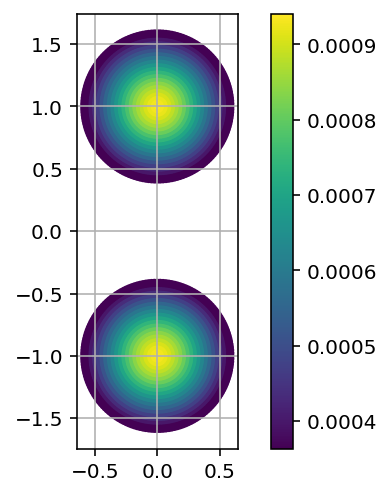

In [9]:
n = X.shape[0]
plt.scatter(X[:,0], X[:,1], 10*np.ones(n),  op)
plt.axis('scaled')
plt.grid(True)
plt.colorbar();

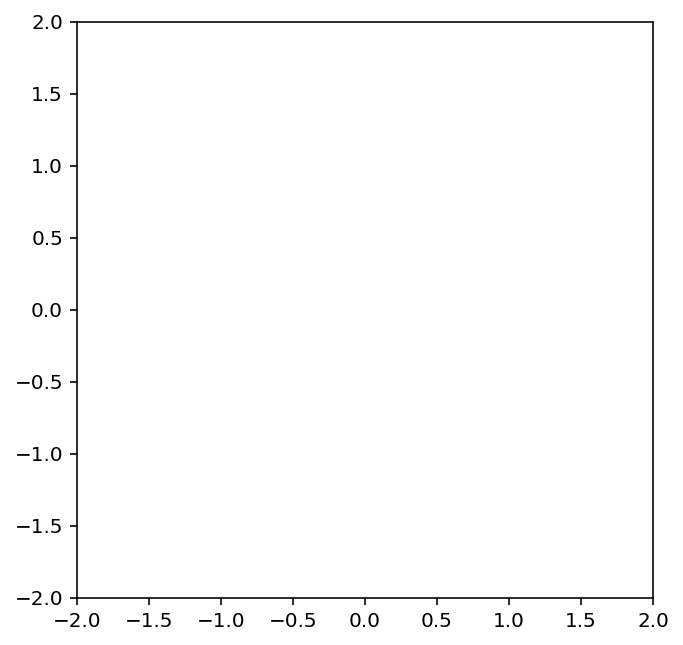

In [10]:
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2));

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=2);

def init():
    particles.set_data([], [])
    return particles,

def animate(i):
    global dt, ax, fig, X
    up, vp = biot(X[:,0], X[:,1], op)
    up, vp = biot(X[:,0] + 0.5 * dt * up, 
                  X[:,1] + 0.5 * dt * vp, op)
    X[:,0] += dt * up
    X[:,1] += dt * vp

    particles.set_data(X[:, 0], X[:, 1])
    return particles,

ani = animation.FuncAnimation(fig, animate, frames=400,
                              interval=10, blit=True, init_func=init);

In [11]:
from IPython.display import HTML

HTML(ani.to_jshtml())